In [110]:
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt
import pickle
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (8,6)

In [11]:
%run ../code/data_proc.py
test_data = read_cdph_test()

In [12]:
test_data = test_data.groupby(['lab_result_date','county','FIPS']).sum()

In [14]:
test_data = test_data.reset_index()

In [18]:
test_data['county'] = test_data['county'].str.title()

In [ ]:
test_data['pos_rate'] = test_data.eval('pos_results / (pos_results + neg_results)')

In [22]:
p9.ggplot(test_data, p9.aes(x='lab_result_date', y='re'))

58

In [23]:
test_data

,lab_result_date,county,FIPS,pos_results,neg_results
0,2020-01-02,San Diego,06073,0,1
1,2020-01-03,Los Angeles,06037,0,2
2,2020-01-03,Riverside,06065,2,0
3,2020-01-03,Sacramento,06067,4,2
4,2020-01-04,Alameda,06001,0,1
...,...,...,...,...,...
23535,2021-04-21,Tulare,06107,1,74
23536,2021-04-21,Tuolumne,06109,0,4
23537,2021-04-21,Ventura,06111,1,195
23538,2021-04-21,Yolo,06113,0,31


In [30]:
hdt_data = pd.read_csv('../data/DeloitteWeekly_v3_LJS_04182021.csv')

In [27]:
with open('../data/davis_CBG.pickle','rb') as file:
    Davis_CBG = pickle.load(file)

In [31]:
geo_nas = hdt_data['CensusGEOID'].isna()
hdt_data.loc[~geo_nas,'CensusGEOID'] = hdt_data.loc[~geo_nas,'CensusGEOID'].astype(int).astype(str).str.zfill(15)
hdt_data['CollectionDateTime'] = pd.to_datetime(hdt_data['CollectionDateTime'])

hdt_data['age_range'] = pd.cut(hdt_data['age'],
       [0,18,25,35,45,55,65,75,85,200],
       right = False,
       labels=['0-17','18-24','25-34','35-44','45-54','55-64','65-74','75-84','85+'])

hdt_data.loc[~geo_nas,'CBG'] = hdt_data.loc[~geo_nas,'CensusGEOID'].str[:-3]

In [36]:
hdt_data.loc[geo_nas,'CBG'] = 'NA'
hdt_data['positive'] = hdt_data['Result'] == 'Detected'
hdt_data['negative'] = hdt_data['Result'] == 'Not Detected'

In [38]:
hdt_data['Date'] = pd.PeriodIndex(hdt_data['CollectionDateTime'],freq='D')

In [43]:
hdt_daily = hdt_data.groupby('Date').sum()[['positive','negative']]

In [44]:
davis_data = hdt_data[hdt_data['CBG'].isin(Davis_CBG)]

In [93]:
yolo_hdt_data = hdt_data[hdt_data['County'] == 'Yolo']

In [46]:
davis_daily = davis_data.groupby('Date').sum()[['positive','negative']]

In [49]:
hdt_daily = hdt_daily.join(hdt_daily.rolling('7D').mean(),rsuffix='_7dav')
hdt_daily['pos_rate'] = hdt_daily.eval('positive / (positive + negative)')
hdt_daily['pos_rate_7dav'] = hdt_daily.eval('positive_7dav / (positive_7dav + negative_7dav)')

In [52]:
davis_daily = davis_daily.join(davis_daily.rolling('7D').mean(),rsuffix='_7dav')
davis_daily['pos_rate'] = davis_daily.eval('positive / (positive + negative)')
davis_daily['pos_rate_7dav'] = davis_daily.eval('positive_7dav / (positive_7dav + negative_7dav)')

In [61]:
ca_daily = test_data.groupby('lab_result_date').sum().rename(columns={'pos_results':'positive', 'neg_results':'negative'})

In [62]:
ca_daily = ca_daily.join(ca_daily.rolling('7D').mean(),rsuffix='_7dav')
ca_daily['pos_rate'] = ca_daily.eval('positive / (positive + negative)')
ca_daily['pos_rate_7dav'] = ca_daily.eval('positive_7dav / (positive_7dav + negative_7dav)')

In [63]:
yolo_daily = test_data.query('FIPS=="06113"')

In [67]:
yolo_daily = yolo_daily.groupby('lab_result_date').sum().rename(columns={'pos_results':'positive', 'neg_results':'negative'})

In [69]:
yolo_daily = yolo_daily.join(yolo_daily.rolling('7D').mean(),rsuffix='_7dav')
yolo_daily['pos_rate'] = yolo_daily.eval('positive / (positive + negative)')
yolo_daily['pos_rate_7dav'] = yolo_daily.eval('positive_7dav / (positive_7dav + negative_7dav)')

In [73]:
yolo_daily = yolo_daily.reset_index().rename(columns={'lab_result_date':'Date'})
ca_daily = ca_daily.reset_index().rename(columns={'lab_result_date':'Date'})

In [78]:
hdt_daily.reset_index(inplace=True)
davis_daily.reset_index(inplace=True)

In [ ]:
p9.ggplot(davis_daily, p9.aes(x='Date',y='pos_rate')) + p9.geom_point()

Text(0, 0.5, 'Pos PPT')

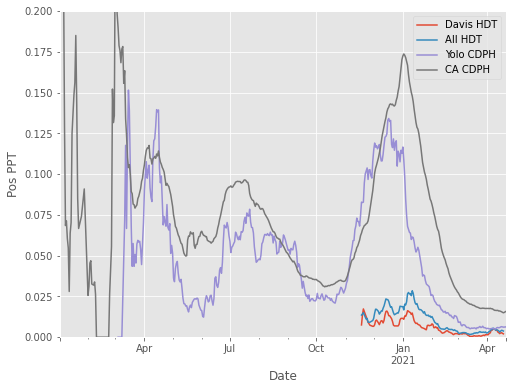

In [128]:
ax = davis_daily.plot('Date','pos_rate_7dav',label='Davis HDT')
hdt_daily.plot('Date','pos_rate_7dav', ax=ax, label='All HDT')
yolo_daily.plot('Date','pos_rate_7dav', ax=ax, label='Yolo CDPH')
ca_daily.plot('Date','pos_rate_7dav', ax=ax, label='CA CDPH')
plt.ylim([0,.2])
plt.ylabel('Pos PPT')

In [120]:
yolo_daily['total_7dav'] = yolo_daily.eval('positive_7dav + negative_7dav')
yolo_daily['total'] = yolo_daily.eval('positive + negative')

<AxesSubplot:xlabel='Date'>

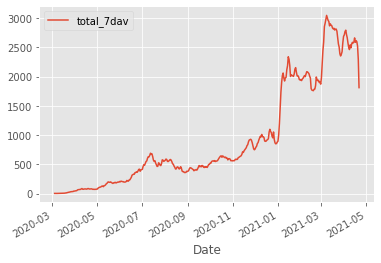

In [91]:
yolo_daily.plot('Date','total_7dav')

In [97]:
yolo_hdt_daily = yolo_hdt_data.groupby('Date').sum()[['positive','negative']]
yolo_hdt_daily = yolo_hdt_daily.join(yolo_hdt_daily.rolling('7D').mean(),rsuffix='_7dav')

In [115]:
yolo_hdt_daily['total'] = yolo_hdt_daily.eval('positive + negative')
yolo_hdt_daily['total_7dav'] = yolo_hdt_daily.eval('positive_7dav + negative_7dav')

In [101]:
yolo_hdt_daily.reset_index(inplace=True)

/home/jsharpna/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff979e6f2b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
/home/jsharpna/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff979e43a30> has a label of '_nolegend_' which cannot be automatically added to the legend.


Text(0, 0.5, 'Total tests')

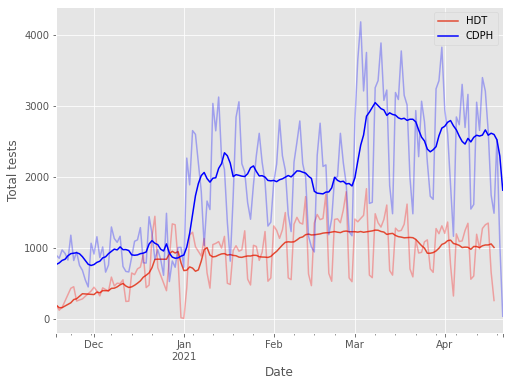

In [127]:
ax = yolo_hdt_daily.plot('Date','total_7dav',label='HDT')
yolo_hdt_daily.plot('Date','total',ax=ax,color='r',alpha=.3,label="_nolegend_")
yolo_daily.query('Date >= "{}"'.format(yolo_hdt_daily['Date'].min())).plot('Date','total_7dav', ax=ax,label='CDPH',color='b')
yolo_daily.query('Date >= "{}"'.format(yolo_hdt_daily['Date'].min())).plot('Date','total', ax=ax, label="_nolegend_",color='b',alpha=.3)
plt.ylabel('Total tests')